# ライブラリのインポート

In [144]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup
from urllib.request import urlopen
from itertools import combinations, permutations
import pandas as pd
import numpy as np
import datetime
import lightgbm as lgb
import requests
import time
import re
import optuna.integration.lightgbm as lgb_o
import matplotlib.pyplot as plt

# 前処理済みのデータ

In [145]:
df = pd.read_csv('./csv/preprocessed_df.csv', index_col=0)
df.head(2)

,枠番,馬番,斤量,単勝,course_len,date,horse_id,jockey_id,rank,齢,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_稍重,ground_state_不良,ground_state_重,性_牡,性_牝,性_セ
201001010101,8,10,54.0,13.7,18.0,2010-08-14,2008100961,1015,1,2,...,1,0,0,1,0,0,0,1,0,0
201001010101,6,7,54.0,7.6,18.0,2010-08-14,2008104484,1091,1,2,...,1,0,0,1,0,0,0,1,0,0


# データの分割

時系列データなので、ランダムにシャッフルすることなく、データを分割する。<br>
30%をテストデータにする方針でコードを書く。

In [146]:
#時系列に沿って訓練データとテストデータに分ける関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

In [147]:
train_data, test_data = split_data(df)

In [148]:
train_data.head(2)

,枠番,馬番,斤量,単勝,course_len,date,horse_id,jockey_id,rank,齢,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_稍重,ground_state_不良,ground_state_重,性_牡,性_牝,性_セ
201006010108,7,12,57.0,4.2,18.0,2010-01-05,2005106677,422,1,5,...,0,1,0,1,0,0,0,1,0,0
201006010108,3,4,57.0,14.9,18.0,2010-01-05,2005103849,1065,1,5,...,0,1,0,1,0,0,0,1,0,0


In [149]:
test_data.head(2)

,枠番,馬番,斤量,単勝,course_len,date,horse_id,jockey_id,rank,齢,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_稍重,ground_state_不良,ground_state_重,性_牡,性_牝,性_セ
201909010409,4,8,57.0,16.0,14.0,2019-03-03,2015106194,1093,1,4,...,0,1,0,0,1,0,0,1,0,0
201909010409,7,14,57.0,4.5,14.0,2019-03-03,2015102499,1102,1,4,...,0,1,0,0,1,0,0,0,0,1


# 訓練データをさらに訓練データ・検証データに分割

In [150]:
train_data, valid_data = split_data(train_data)

In [151]:
train_data.columns

Index(['枠番', '馬番', '斤量', '単勝', 'course_len', 'date', 'horse_id', 'jockey_id',
       'rank', '齢', '体重', '体重変化', '開催', 'n_horses', 'jockey_label',
       'horse_label', 'weather_晴', 'weather_曇', 'weather_小雨', 'weather_雨',
       'weather_小雪', 'weather_雪', 'race_type_芝', 'race_type_ダート',
       'race_type_障害', 'ground_state_良', 'ground_state_稍重', 'ground_state_不良',
       'ground_state_重', '性_牡', '性_牝', '性_セ'],
      dtype='object')

In [152]:
# 不要なカラムの削除と、目的変数の切り分け（単勝オッズは抜いてみた）
# X_train = train_data.drop(['date', '単勝', 'rank'], axis=1)
# y_train = train_data['rank']
# X_valid = valid_data.drop(['date', '単勝', 'rank'], axis=1)
# y_valid = valid_data['rank']


# 不要なカラムの削除と、目的変数の切り分け（単勝オッズは抜いてみた）
X_train = train_data.drop(['date', 'rank'], axis=1)
y_train = train_data['rank']
X_valid = valid_data.drop(['date', 'rank'], axis=1)
y_valid = valid_data['rank']

# optunaでパラメータチューニング

In [153]:
c

[I 2023-02-13 22:53:03,045] A new study created in memory with name: no-name-5955ac58-4640-48df-9f83-b66ff3625992
feature_fraction, val_score: inf:   0%|               | 0/7 [00:00<?, ?it/s]/Users/yashigeyuki/opt/anaconda3/envs/horse/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/yashigeyuki/opt/anaconda3/envs/horse/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.401151:  14%|2 | 1/7 [00:01<00:09,  1.62s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.397178	valid_1's binary_logloss: 0.401151
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.401136:  29%|5 | 2/7 [00:03<00:07,  1.51s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.396992	valid_1's binary_logloss: 0.401136
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.401119:  43%|8 | 3/7 [00:04<00:05,  1.49s/it]

Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.396943	valid_1's binary_logloss: 0.401119
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.401119:  57%|#1| 4/7 [00:06<00:04,  1.58s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.39652	valid_1's binary_logloss: 0.40122
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.394982	valid_1's binary_logloss: 0.401473


feature_fraction, val_score: 0.401119:  71%|#4| 5/7 [00:08<00:03,  1.96s/it]

Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.394124	valid_1's binary_logloss: 0.401406
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.401119:  86%|#7| 6/7 [00:10<00:01,  2.00s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.396075	valid_1's binary_logloss: 0.401218
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.401119: 100%|##| 7/7 [00:13<00:00,  1.86s/it]


Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.396283	valid_1's binary_logloss: 0.401502


num_leaves, val_score: 0.401119:   0%|               | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.401119:   5%|3      | 1/20 [00:01<00:28,  1.51s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.38961	valid_1's binary_logloss: 0.402176
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.401119:  10%|7      | 2/20 [00:03<00:27,  1.52s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.393472	valid_1's binary_logloss: 0.4017
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.401119:  15%|#      | 3/20 [00:06<00:38,  2.27s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.392253	valid_1's binary_logloss: 0.402095
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.401119:  20%|#4     | 4/20 [00:10<00:47,  2.99s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.384713	valid_1's binary_logloss: 0.402924
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399627	valid_1's binary_logloss: 0.400813


num_leaves, val_score: 0.400600:  25%|#7     | 5/20 [00:13<00:43,  2.89s/it]

Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.399361	valid_1's binary_logloss: 0.4006
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400600:  30%|##1    | 6/20 [00:15<00:39,  2.80s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.396299	valid_1's binary_logloss: 0.40111
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400600:  35%|##4    | 7/20 [00:19<00:38,  2.99s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.387713	valid_1's binary_logloss: 0.40262
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400600:  40%|##8    | 8/20 [00:23<00:41,  3.42s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.384967	valid_1's binary_logloss: 0.402965
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400600:  45%|###1   | 9/20 [00:25<00:33,  3.09s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.396872	valid_1's binary_logloss: 0.401147
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400600:  50%|###   | 10/20 [00:28<00:30,  3.10s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.388128	valid_1's binary_logloss: 0.402487
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.400218	valid_1's binary_logloss: 0.401421
[200]	valid_0's binary_logloss: 0.399666	valid_1's binary_logloss: 0.400823


num_leaves, val_score: 0.400600:  55%|###3  | 11/20 [00:31<00:27,  3.09s/it]

[300]	valid_0's binary_logloss: 0.399491	valid_1's binary_logloss: 0.400711
Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.399495	valid_1's binary_logloss: 0.400704
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400536:  60%|###6  | 12/20 [00:34<00:22,  2.86s/it]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.398522	valid_1's binary_logloss: 0.400536
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.400218	valid_1's binary_logloss: 0.401421
[200]	valid_0's binary_logloss: 0.399666	valid_1's binary_logloss: 0.400823


num_leaves, val_score: 0.400536:  65%|###9  | 13/20 [00:37<00:19,  2.83s/it]

[300]	valid_0's binary_logloss: 0.399491	valid_1's binary_logloss: 0.400711
Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.399495	valid_1's binary_logloss: 0.400704
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400536:  70%|####1 | 14/20 [00:38<00:15,  2.52s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.393229	valid_1's binary_logloss: 0.401622
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400536:  75%|####5 | 15/20 [00:40<00:11,  2.23s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.395841	valid_1's binary_logloss: 0.40156
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400536:  80%|####8 | 16/20 [00:42<00:08,  2.24s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.382307	valid_1's binary_logloss: 0.402951
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400536:  85%|#####1| 17/20 [00:44<00:06,  2.19s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.392928	valid_1's binary_logloss: 0.401846
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400536:  90%|#####4| 18/20 [00:47<00:04,  2.38s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.397333	valid_1's binary_logloss: 0.401065
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400536:  95%|#####6| 19/20 [00:50<00:02,  2.50s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.390767	valid_1's binary_logloss: 0.401995
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.400536: 100%|######| 20/20 [00:52<00:00,  2.64s/it]


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.393762	valid_1's binary_logloss: 0.401452


bagging, val_score: 0.400536:   0%|                  | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400536:  10%|#         | 1/10 [00:02<00:21,  2.43s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.398948	valid_1's binary_logloss: 0.400574
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400536:  20%|##        | 2/10 [00:06<00:28,  3.57s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.399191	valid_1's binary_logloss: 0.400587
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400536:  30%|###       | 3/10 [00:22<01:04,  9.28s/it]

[100]	valid_0's binary_logloss: 0.398243	valid_1's binary_logloss: 0.400726
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.398338	valid_1's binary_logloss: 0.400667
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400480:  40%|####      | 4/10 [00:26<00:42,  7.01s/it]

[100]	valid_0's binary_logloss: 0.398262	valid_1's binary_logloss: 0.400576
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.39841	valid_1's binary_logloss: 0.40048
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400480:  50%|#####     | 5/10 [00:29<00:28,  5.62s/it]

Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.39898	valid_1's binary_logloss: 0.400693
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400480:  60%|######    | 6/10 [00:33<00:19,  4.96s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.398869	valid_1's binary_logloss: 0.400598
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400480:  70%|#######   | 7/10 [00:35<00:12,  4.04s/it]

Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.398912	valid_1's binary_logloss: 0.400625
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400480:  80%|########  | 8/10 [00:37<00:06,  3.44s/it]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.398735	valid_1's binary_logloss: 0.400546
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400480:  90%|######### | 9/10 [00:40<00:03,  3.32s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.39872	valid_1's binary_logloss: 0.400539
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.400480: 100%|#########| 10/10 [00:42<00:00,  4.28s/it]


Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.398733	valid_1's binary_logloss: 0.400559


feature_fraction_stage2, val_score: 0.400480:   0%|   | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.400480:  17%|1| 1/6 [00:02<00:10,  2.0[I 2023-02-13 22:54:53,755] Trial 37 finished with value: 0.40049972874279666 and parameters: {'feature_fraction': 0.852}. Best is trial 37 with value: 0.40049972874279666.
feature_fraction_stage2, val_score: 0.400480:  17%|1| 1/6 [00:02<00:10,  2.0

[100]	valid_0's binary_logloss: 0.398319	valid_1's binary_logloss: 0.4005
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.398319	valid_1's binary_logloss: 0.4005
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.400472:  33%|3| 2/6 [00:04<00:09,  2.2[I 2023-02-13 22:54:56,201] Trial 38 finished with value: 0.4004723469260217 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 38 with value: 0.4004723469260217.
feature_fraction_stage2, val_score: 0.400472:  33%|3| 2/6 [00:04<00:09,  2.2

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400563
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398422	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.400472:  50%|5| 3/6 [00:06<00:06,  2.2[I 2023-02-13 22:54:58,334] Trial 39 finished with value: 0.4004801344354516 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 38 with value: 0.4004723469260217.
feature_fraction_stage2, val_score: 0.400472:  50%|5| 3/6 [00:06<00:06,  2.2

[100]	valid_0's binary_logloss: 0.398262	valid_1's binary_logloss: 0.400576
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.39841	valid_1's binary_logloss: 0.40048
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.400472:  67%|6| 4/6 [00:09<00:04,  2.3[I 2023-02-13 22:55:00,819] Trial 40 finished with value: 0.4004801344354516 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 38 with value: 0.4004723469260217.
feature_fraction_stage2, val_score: 0.400472:  67%|6| 4/6 [00:09<00:04,  2.3

[100]	valid_0's binary_logloss: 0.398262	valid_1's binary_logloss: 0.400576
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.39841	valid_1's binary_logloss: 0.40048
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.400472:  83%|8| 5/6 [00:11<00:02,  2.3[I 2023-02-13 22:55:03,107] Trial 41 finished with value: 0.40047927590449955 and parameters: {'feature_fraction': 0.82}. Best is trial 38 with value: 0.4004723469260217.
feature_fraction_stage2, val_score: 0.400472:  83%|8| 5/6 [00:11<00:02,  2.3

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.398507	valid_1's binary_logloss: 0.400479
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.400472: 100%|#| 6/6 [00:14<00:00,  2.5

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.39866	valid_1's binary_logloss: 0.400487


[I 2023-02-13 22:55:06,186] Trial 42 finished with value: 0.4004865655993839 and parameters: {'feature_fraction': 0.948}. Best is trial 38 with value: 0.4004723469260217.
feature_fraction_stage2, val_score: 0.400472: 100%|#| 6/6 [00:14<00:00,  2.4
regularization_factors, val_score: 0.400472:   0%|   | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400472:   5%| | 1/20 [00:02<00:44,  2.3[I 2023-02-13 22:55:08,569] Trial 43 finished with value: 0.40047233842024565 and parameters: {'lambda_l1': 0.0007773998922821829, 'lambda_l2': 3.2012859298995277e-06}. Best is trial 43 with value: 0.40047233842024565.
regularization_factors, val_score: 0.400472:   5%| | 1/20 [00:02<00:44,  2.3

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400563
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398422	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400472:  10%|1| 2/20 [00:05<00:46,  2.5[I 2023-02-13 22:55:11,288] Trial 44 finished with value: 0.40047586995886125 and parameters: {'lambda_l1': 6.616957066014342e-05, 'lambda_l2': 0.400853048601546}. Best is trial 43 with value: 0.40047233842024565.
regularization_factors, val_score: 0.400472:  10%|1| 2/20 [00:05<00:46,  2.5

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.398502	valid_1's binary_logloss: 0.400476
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400472:  15%|1| 3/20 [00:07<00:41,  2.4[I 2023-02-13 22:55:13,543] Trial 45 finished with value: 0.4004723469238754 and parameters: {'lambda_l1': 1.1027313099672533e-08, 'lambda_l2': 1.242001404761155e-07}. Best is trial 43 with value: 0.40047233842024565.
regularization_factors, val_score: 0.400472:  15%|1| 3/20 [00:07<00:41,  2.4

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400563
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398422	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400472:  20%|2| 4/20 [00:09<00:37,  2.3[I 2023-02-13 22:55:15,829] Trial 46 finished with value: 0.4005598079181634 and parameters: {'lambda_l1': 0.010882827930218712, 'lambda_l2': 0.2708162972907513}. Best is trial 43 with value: 0.40047233842024565.
regularization_factors, val_score: 0.400472:  20%|2| 4/20 [00:09<00:37,  2.3

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.398618	valid_1's binary_logloss: 0.40056
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400472:  25%|2| 5/20 [00:11<00:35,  2.3[I 2023-02-13 22:55:18,097] Trial 47 finished with value: 0.4004723182064934 and parameters: {'lambda_l1': 1.6996492507894156e-07, 'lambda_l2': 0.0014991323116035308}. Best is trial 47 with value: 0.4004723182064934.
regularization_factors, val_score: 0.400472:  25%|2| 5/20 [00:11<00:35,  2.3

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400562
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398423	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400472:  30%|3| 6/20 [00:14<00:32,  2.3[I 2023-02-13 22:55:20,462] Trial 48 finished with value: 0.40050560182451117 and parameters: {'lambda_l1': 1.0517138394360073, 'lambda_l2': 7.635176818135586e-07}. Best is trial 47 with value: 0.4004723182064934.
regularization_factors, val_score: 0.400472:  30%|3| 6/20 [00:14<00:32,  2.3

[100]	valid_0's binary_logloss: 0.398324	valid_1's binary_logloss: 0.400602
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398489	valid_1's binary_logloss: 0.400506
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400472:  35%|3| 7/20 [00:16<00:29,  2.3[I 2023-02-13 22:55:22,657] Trial 49 finished with value: 0.40047234691940825 and parameters: {'lambda_l1': 4.655367559816141e-07, 'lambda_l2': 9.449134137745608e-08}. Best is trial 47 with value: 0.4004723182064934.
regularization_factors, val_score: 0.400472:  35%|3| 7/20 [00:16<00:29,  2.3

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400563
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398422	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  40%|4| 8/20 [00:19<00:29,  2.4[I 2023-02-13 22:55:25,565] Trial 50 finished with value: 0.4004427485061476 and parameters: {'lambda_l1': 9.490245203532942e-07, 'lambda_l2': 6.421168438428032}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  40%|4| 8/20 [00:19<00:29,  2.4

[100]	valid_0's binary_logloss: 0.398383	valid_1's binary_logloss: 0.400463
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.398507	valid_1's binary_logloss: 0.400443
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  45%|4| 9/20 [00:21<00:25,  2.3[I 2023-02-13 22:55:27,612] Trial 51 finished with value: 0.400481970908187 and parameters: {'lambda_l1': 0.2019055894080857, 'lambda_l2': 3.5275169933928286e-07}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  45%|4| 9/20 [00:21<00:25,  2.3

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.398577	valid_1's binary_logloss: 0.400482
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  50%|5| 10/20 [00:23<00:22,  2.[I 2023-02-13 22:55:29,578] Trial 52 finished with value: 0.4004832772456694 and parameters: {'lambda_l1': 0.22183125618514202, 'lambda_l2': 2.9286247167445133e-06}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  50%|5| 10/20 [00:23<00:22,  2.

[100]	valid_0's binary_logloss: 0.39829	valid_1's binary_logloss: 0.400547
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.398472	valid_1's binary_logloss: 0.400483
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  55%|5| 11/20 [00:25<00:20,  2.[I 2023-02-13 22:55:31,872] Trial 53 finished with value: 0.400510576546946 and parameters: {'lambda_l1': 3.005784364160781e-05, 'lambda_l2': 8.38297710342227}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  55%|5| 11/20 [00:25<00:20,  2.

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.398702	valid_1's binary_logloss: 0.400511
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  60%|6| 12/20 [00:28<00:18,  2.[I 2023-02-13 22:55:34,345] Trial 54 finished with value: 0.4004723401554088 and parameters: {'lambda_l1': 1.187191828926573e-06, 'lambda_l2': 0.00035256149866694594}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  60%|6| 12/20 [00:28<00:18,  2.

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400562
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398423	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  65%|6| 13/20 [00:30<00:16,  2.[I 2023-02-13 22:55:36,709] Trial 55 finished with value: 0.4004723009083789 and parameters: {'lambda_l1': 1.5326118358532145e-08, 'lambda_l2': 0.0024056973309017414}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  65%|6| 13/20 [00:30<00:16,  2.

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400562
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398423	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  70%|7| 14/20 [00:33<00:14,  2.[I 2023-02-13 22:55:39,289] Trial 56 finished with value: 0.40046463038258134 and parameters: {'lambda_l1': 1.8773006530383478e-08, 'lambda_l2': 0.0053577653024348805}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  70%|7| 14/20 [00:33<00:14,  2.

[100]	valid_0's binary_logloss: 0.398262	valid_1's binary_logloss: 0.400569
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398434	valid_1's binary_logloss: 0.400465
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  75%|7| 15/20 [00:35<00:11,  2.[I 2023-02-13 22:55:41,220] Trial 57 finished with value: 0.4004738025533113 and parameters: {'lambda_l1': 4.671929389608935e-06, 'lambda_l2': 0.031213977783275056}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  75%|7| 15/20 [00:35<00:11,  2.

[100]	valid_0's binary_logloss: 0.398252	valid_1's binary_logloss: 0.400496
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.398382	valid_1's binary_logloss: 0.400474
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  80%|8| 16/20 [00:37<00:08,  2.[I 2023-02-13 22:55:43,271] Trial 58 finished with value: 0.4004723459633982 and parameters: {'lambda_l1': 9.888647633264006e-08, 'lambda_l2': 5.002236173419203e-05}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  80%|8| 16/20 [00:37<00:08,  2.

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400563
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398422	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  85%|8| 17/20 [00:39<00:06,  2.[I 2023-02-13 22:55:45,260] Trial 59 finished with value: 0.4005243381784541 and parameters: {'lambda_l1': 1.548093116837356e-06, 'lambda_l2': 8.883683170189627}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  85%|8| 17/20 [00:39<00:06,  2.

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.398676	valid_1's binary_logloss: 0.400524
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  90%|9| 18/20 [00:41<00:04,  2.[I 2023-02-13 22:55:47,209] Trial 60 finished with value: 0.4004740763827764 and parameters: {'lambda_l1': 1.0097469443659385e-07, 'lambda_l2': 0.020503066366016755}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  90%|9| 18/20 [00:41<00:04,  2.

[100]	valid_0's binary_logloss: 0.398249	valid_1's binary_logloss: 0.400497
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.39838	valid_1's binary_logloss: 0.400474
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.400443:  95%|9| 19/20 [00:43<00:02,  2.[I 2023-02-13 22:55:49,316] Trial 61 finished with value: 0.40047234683002986 and parameters: {'lambda_l1': 8.921249493135996e-06, 'lambda_l2': 1.505425473668919e-08}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443:  95%|9| 19/20 [00:43<00:02,  2.

[100]	valid_0's binary_logloss: 0.398247	valid_1's binary_logloss: 0.400563
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398422	valid_1's binary_logloss: 0.400472
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.398306	valid_1's binary_logloss: 0.400524


regularization_factors, val_score: 0.400443: 100%|#| 20/20 [00:45<00:00,  2.[I 2023-02-13 22:55:51,842] Trial 62 finished with value: 0.400494819862985 and parameters: {'lambda_l1': 0.0002663058340698051, 'lambda_l2': 0.7995310882728119}. Best is trial 50 with value: 0.4004427485061476.
regularization_factors, val_score: 0.400443: 100%|#| 20/20 [00:45<00:00,  2.


Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.397835	valid_1's binary_logloss: 0.400495


min_data_in_leaf, val_score: 0.400443:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.400443:  20%|4 | 1/5 [00:02<00:08,  2.00s/it]

[100]	valid_0's binary_logloss: 0.398383	valid_1's binary_logloss: 0.400463
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.398507	valid_1's binary_logloss: 0.400443
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.400434:  40%|8 | 2/5 [00:03<00:05,  1.97s/it]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.398543	valid_1's binary_logloss: 0.400434
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.400434:  60%|#2| 3/5 [00:06<00:04,  2.03s/it]

[100]	valid_0's binary_logloss: 0.398383	valid_1's binary_logloss: 0.400463
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.398507	valid_1's binary_logloss: 0.400443
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.400434:  80%|#6| 4/5 [00:09<00:02,  2.56s/it]

[100]	valid_0's binary_logloss: 0.398383	valid_1's binary_logloss: 0.400463
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.398507	valid_1's binary_logloss: 0.400443
[LightGBM] [Info] Number of positive: 66626, number of negative: 251914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 318540, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209161 -> initscore=-1.329993
[LightGBM] [Info] Start training from score -1.329993
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.400426: 100%|##| 5/5 [00:11<00:00,  2.29s/it]

[100]	valid_0's binary_logloss: 0.398379	valid_1's binary_logloss: 0.400481
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.398513	valid_1's binary_logloss: 0.400426


In [154]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 9.490245203532942e-07,
 'lambda_l2': 6.421168438428032,
 'num_leaves': 9,
 'feature_fraction': 0.9799999999999999,
 'bagging_fraction': 0.802449450836738,
 'bagging_freq': 6,
 'min_child_samples': 100,
 'num_iterations': 1000,
 'early_stopping_round': 10}

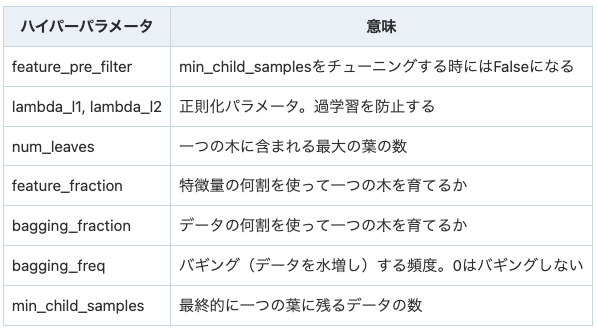

# LightGBMで学習

In [155]:
# 検証データも含めるために元のデータから分割
train, test = split_data(df)

# X_train = train.drop(['rank', 'date', '単勝'], axis=1)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']

X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

params = lgb_clf_o.params.copy()
del(params['early_stopping_round'])


lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

/Users/yashigeyuki/opt/anaconda3/envs/horse/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9799999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9799999999999999
[LightGBM] [Warning] bagging_fraction is set=0.802449450836738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.802449450836738
[LightGBM] [Warning] lambda_l2 is set=6.421168438428032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.421168438428032
[LightGBM] [Warning] lambda_l1 is set=9.490245203532942e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.490245203532942e-07


LGBMClassifier(bagging_fraction=0.802449450836738, bagging_freq=6,
               feature_fraction=0.9799999999999999, feature_pre_filter=False,
               lambda_l1=9.490245203532942e-07, lambda_l2=6.421168438428032,
               min_child_samples=100, num_iterations=1000, num_leaves=9,
               objective='binary', random_state=100)

In [76]:
X_train

,枠番,馬番,斤量,course_len,horse_id,jockey_id,齢,体重,体重変化,開催,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_稍重,ground_state_不良,ground_state_重,性_牡,性_牝,性_セ
201006010108,7,12,57.0,18.0,2005106677,422,5,520.0,6.0,6,...,0,1,0,1,0,0,0,1,0,0
201006010108,3,4,57.0,18.0,2005103849,1065,5,498.0,6.0,6,...,0,1,0,1,0,0,0,1,0,0
201006010108,4,6,56.0,18.0,2006102986,641,4,504.0,-8.0,6,...,0,1,0,1,0,0,0,1,0,0
201006010108,4,5,55.0,18.0,2004110041,733,6,528.0,-2.0,6,...,0,1,0,1,0,0,0,0,1,0
201006010108,6,9,57.0,18.0,2004102881,1096,6,520.0,-2.0,6,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201909010408,6,6,56.0,18.0,2016105169,5203,3,456.0,6.0,9,...,1,0,0,1,0,0,0,1,0,0
201909010408,4,4,56.0,18.0,2016104841,1088,3,466.0,8.0,9,...,1,0,0,1,0,0,0,1,0,0
201909010408,1,1,54.0,18.0,2016101679,5115,3,426.0,-8.0,9,...,1,0,0,1,0,0,0,0,1,0
201909010408,7,7,56.0,18.0,2016104400,1102,3,460.0,-2.0,9,...,1,0,0,1,0,0,0,1,0,0


# 予測

In [156]:
# y_predict = lgb_clf.predict(X_test.drop(['単勝'], axis=1).values)
# y_predict_proba = lgb_clf.predict_proba(X_test.drop(['単勝'], axis=1).values)
y_predict = lgb_clf.predict(X_test.values)
y_predict_proba = lgb_clf.predict_proba(X_test.values)

In [157]:
feature_importance_dict = dict()

for c, i in zip(X_train.columns, lgb_clf.feature_importances_):
    feature_importance_dict[c] = i

feature_importance_dict = sorted(feature_importance_dict.items(), key=lambda x:x[1], reverse=True)
feature_importance_dict[:10]

[('単勝', 1323),
 ('jockey_id', 1101),
 ('horse_id', 1064),
 ('体重', 952),
 ('体重変化', 566),
 ('馬番', 459),
 ('course_len', 378),
 ('開催', 376),
 ('n_horses', 367),
 ('斤量', 287)]

In [158]:
y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [159]:
y_predict_proba[:,1]

array([0.18583839, 0.48843801, 0.21527116, ..., 0.20159589, 0.07930137,
       0.1248944 ])

In [160]:
roc_auc_score(y_test.values, y_predict_proba[:,1])

0.8100832442842594

In [162]:
import pickle

file = 'model.pkl'
pickle.dump(lgb_clf, open(file, 'wb'))

In [163]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452359 entries, 201006010108 to 201909010408
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   枠番               452359 non-null  int64  
 1   馬番               452359 non-null  int64  
 2   斤量               452359 non-null  float64
 3   単勝               452359 non-null  float64
 4   course_len       452359 non-null  float64
 5   horse_id         452359 non-null  int64  
 6   jockey_id        452359 non-null  int64  
 7   齢                452359 non-null  int64  
 8   体重               452358 non-null  float64
 9   体重変化             452358 non-null  float64
 10  開催               452359 non-null  int64  
 11  n_horses         452359 non-null  int64  
 12  jockey_label     452359 non-null  int64  
 13  horse_label      452359 non-null  int64  
 14  weather_晴        452359 non-null  int64  
 15  weather_曇        452359 non-null  int64  
 16  weather_小雨       4523

# 最終モデル

In [177]:
train_data, valid_data = split_data(df)
# 不要なカラムの削除と、目的変数の切り分け（単勝オッズは抜いてみた）
X_train = train_data.drop(['date', 'rank'], axis=1)
y_train = train_data['rank']
X_valid = valid_data.drop(['date', 'rank'], axis=1)
y_valid = valid_data['rank']

#データセットを作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective': 'binary', #今回は0or1の二値予測なのでbinaryを指定
    'random_state': 100
}

#チューニング実行
lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        verbose_eval=100,
                        early_stopping_rounds=10,
                        optuna_seed=100 #optunaのseed固定
                        )

[I 2023-02-14 00:45:19,887] A new study created in memory with name: no-name-8f9a7dcd-6138-4838-b949-86f2825f3091
feature_fraction, val_score: inf:   0%|               | 0/7 [00:00<?, ?it/s]/Users/yashigeyuki/opt/anaconda3/envs/horse/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/yashigeyuki/opt/anaconda3/envs/horse/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.411078:  14%|2 | 1/7 [00:02<00:17,  2.94s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.397388	valid_1's binary_logloss: 0.411078
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410946:  29%|5 | 2/7 [00:05<00:13,  2.65s/it]

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.397013	valid_1's binary_logloss: 0.410946
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410945:  43%|8 | 3/7 [00:07<00:09,  2.46s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.398857	valid_1's binary_logloss: 0.410945
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410945:  57%|#1| 4/7 [00:09<00:07,  2.41s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.398609	valid_1's binary_logloss: 0.411028
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410902:  71%|#4| 5/7 [00:12<00:04,  2.42s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.398274	valid_1's binary_logloss: 0.410902
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410902:  86%|#7| 6/7 [00:15<00:02,  2.50s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.397629	valid_1's binary_logloss: 0.41091
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410902: 100%|##| 7/7 [00:17<00:00,  2.47s/it]


Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.398252	valid_1's binary_logloss: 0.411073


num_leaves, val_score: 0.410902:   0%|               | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410902:   5%|3      | 1/20 [00:02<00:47,  2.51s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.391425	valid_1's binary_logloss: 0.412494
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410902:  10%|7      | 2/20 [00:04<00:44,  2.49s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.394165	valid_1's binary_logloss: 0.41168
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410902:  15%|#      | 3/20 [00:07<00:42,  2.49s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.394359	valid_1's binary_logloss: 0.412128
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410902:  20%|#4     | 4/20 [00:10<00:42,  2.66s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.386469	valid_1's binary_logloss: 0.413166
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399929	valid_1's binary_logloss: 0.4104


num_leaves, val_score: 0.410236:  25%|#7     | 5/20 [00:13<00:39,  2.67s/it]

Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.399669	valid_1's binary_logloss: 0.410236
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  30%|##1    | 6/20 [00:15<00:36,  2.58s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.39759	valid_1's binary_logloss: 0.411043
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  35%|##4    | 7/20 [00:17<00:33,  2.55s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.390473	valid_1's binary_logloss: 0.412853
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  40%|##8    | 8/20 [00:20<00:31,  2.60s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.387079	valid_1's binary_logloss: 0.413126
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  45%|###1   | 9/20 [00:23<00:28,  2.62s/it]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.3977	valid_1's binary_logloss: 0.411207
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  50%|###   | 10/20 [00:25<00:26,  2.60s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.390952	valid_1's binary_logloss: 0.412297
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.400962	valid_1's binary_logloss: 0.411323
[200]	valid_0's binary_logloss: 0.399944	valid_1's binary_logloss: 0.41045


num_leaves, val_score: 0.410236:  55%|###3  | 11/20 [00:29<00:26,  2.90s/it]

Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.399823	valid_1's binary_logloss: 0.4104
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  60%|###6  | 12/20 [00:31<00:21,  2.69s/it]

Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.39936	valid_1's binary_logloss: 0.410307
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.400962	valid_1's binary_logloss: 0.411323
[200]	valid_0's binary_logloss: 0.399944	valid_1's binary_logloss: 0.41045


num_leaves, val_score: 0.410236:  65%|###9  | 13/20 [00:35<00:20,  2.96s/it]

Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.399823	valid_1's binary_logloss: 0.4104
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  70%|####1 | 14/20 [00:37<00:16,  2.83s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.394628	valid_1's binary_logloss: 0.411754
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  75%|####5 | 15/20 [00:40<00:13,  2.69s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.396719	valid_1's binary_logloss: 0.411505
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  80%|####8 | 16/20 [00:42<00:10,  2.71s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.387807	valid_1's binary_logloss: 0.413659
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  85%|#####1| 17/20 [00:45<00:07,  2.62s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.394761	valid_1's binary_logloss: 0.411852
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  90%|#####4| 18/20 [00:47<00:04,  2.47s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.39871	valid_1's binary_logloss: 0.410756
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236:  95%|#####6| 19/20 [00:50<00:02,  2.50s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.39405	valid_1's binary_logloss: 0.412024
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410236: 100%|######| 20/20 [00:53<00:00,  2.66s/it]


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.396298	valid_1's binary_logloss: 0.41146


bagging, val_score: 0.410236:   0%|                  | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.410236:  10%|#         | 1/10 [00:03<00:34,  3.84s/it]

[100]	valid_0's binary_logloss: 0.399932	valid_1's binary_logloss: 0.41049
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.399993	valid_1's binary_logloss: 0.410407
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410489


bagging, val_score: 0.410236:  20%|##        | 2/10 [00:08<00:34,  4.35s/it]

Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.399725	valid_1's binary_logloss: 0.410341
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399907	valid_1's binary_logloss: 0.410423


bagging, val_score: 0.410236:  30%|###       | 3/10 [00:11<00:27,  3.86s/it]

Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.399873	valid_1's binary_logloss: 0.410395
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399941	valid_1's binary_logloss: 0.410419


bagging, val_score: 0.410236:  40%|####      | 4/10 [00:15<00:22,  3.73s/it]

Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.399708	valid_1's binary_logloss: 0.410243
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399934	valid_1's binary_logloss: 0.41041


bagging, val_score: 0.410236:  50%|#####     | 5/10 [00:17<00:16,  3.32s/it]

Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.399753	valid_1's binary_logloss: 0.410292
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399928	valid_1's binary_logloss: 0.410386


bagging, val_score: 0.410236:  60%|######    | 6/10 [00:21<00:12,  3.23s/it]

Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.399808	valid_1's binary_logloss: 0.410316
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399918	valid_1's binary_logloss: 0.410448


bagging, val_score: 0.410236:  70%|#######   | 7/10 [00:23<00:09,  3.12s/it]

Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.399736	valid_1's binary_logloss: 0.410347
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.410236:  80%|########  | 8/10 [00:26<00:05,  2.91s/it]

[100]	valid_0's binary_logloss: 0.399945	valid_1's binary_logloss: 0.410618
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.399995	valid_1's binary_logloss: 0.410533
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39992	valid_1's binary_logloss: 0.410386


bagging, val_score: 0.410211:  90%|######### | 9/10 [00:30<00:03,  3.38s/it]

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399612	valid_1's binary_logloss: 0.410211
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399921	valid_1's binary_logloss: 0.410395


bagging, val_score: 0.410211: 100%|#########| 10/10 [00:34<00:00,  3.46s/it]


Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.399689	valid_1's binary_logloss: 0.410248


feature_fraction_stage2, val_score: 0.410211:   0%|   | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


feature_fraction_stage2, val_score: 0.410204:  17%|1| 1/6 [00:03<00:19,  3.9[I 2023-02-14 00:47:09,004] Trial 37 finished with value: 0.41020431590965467 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 0.41020431590965467.
feature_fraction_stage2, val_score: 0.410204:  17%|1| 1/6 [00:03<00:19,  3.9

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399619	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39992	valid_1's binary_logloss: 0.410386


feature_fraction_stage2, val_score: 0.410204:  33%|3| 2/6 [00:07<00:15,  3.9[I 2023-02-14 00:47:12,868] Trial 38 finished with value: 0.4102114118981729 and parameters: {'feature_fraction': 0.616}. Best is trial 37 with value: 0.41020431590965467.
feature_fraction_stage2, val_score: 0.410204:  33%|3| 2/6 [00:07<00:15,  3.9

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399612	valid_1's binary_logloss: 0.410211
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39992	valid_1's binary_logloss: 0.410386


feature_fraction_stage2, val_score: 0.410204:  50%|5| 3/6 [00:12<00:12,  4.0[I 2023-02-14 00:47:17,084] Trial 39 finished with value: 0.4102114118981729 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 0.41020431590965467.
feature_fraction_stage2, val_score: 0.410204:  50%|5| 3/6 [00:12<00:12,  4.0

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399612	valid_1's binary_logloss: 0.410211
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399925	valid_1's binary_logloss: 0.410333


feature_fraction_stage2, val_score: 0.410204:  67%|6| 4/6 [00:15<00:07,  3.9[I 2023-02-14 00:47:20,853] Trial 40 finished with value: 0.4102065189637711 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 0.41020431590965467.
feature_fraction_stage2, val_score: 0.410204:  67%|6| 4/6 [00:15<00:07,  3.9

Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.399686	valid_1's binary_logloss: 0.410207
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399933	valid_1's binary_logloss: 0.41038


feature_fraction_stage2, val_score: 0.410204:  83%|8| 5/6 [00:20<00:04,  4.0[I 2023-02-14 00:47:25,161] Trial 41 finished with value: 0.4102051734503014 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.41020431590965467.
feature_fraction_stage2, val_score: 0.410204:  83%|8| 5/6 [00:20<00:04,  4.0

Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.399611	valid_1's binary_logloss: 0.410205
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399989	valid_1's binary_logloss: 0.410483


feature_fraction_stage2, val_score: 0.410204: 100%|#| 6/6 [00:23<00:00,  3.9[I 2023-02-14 00:47:28,910] Trial 42 finished with value: 0.4102765730202861 and parameters: {'feature_fraction': 0.52}. Best is trial 37 with value: 0.41020431590965467.
feature_fraction_stage2, val_score: 0.410204: 100%|#| 6/6 [00:23<00:00,  3.9


Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.399646	valid_1's binary_logloss: 0.410277


regularization_factors, val_score: 0.410204:   0%|   | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


regularization_factors, val_score: 0.410204:   5%| | 1/20 [00:03<01:13,  3.8[I 2023-02-14 00:47:32,770] Trial 43 finished with value: 0.41020431690859055 and parameters: {'lambda_l1': 0.0007773998922821829, 'lambda_l2': 3.2012859298995277e-06}. Best is trial 43 with value: 0.41020431690859055.
regularization_factors, val_score: 0.410204:   5%| | 1/20 [00:03<01:13,  3.8

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399619	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399937	valid_1's binary_logloss: 0.410374


regularization_factors, val_score: 0.410176:  10%|1| 2/20 [00:08<01:15,  4.2[I 2023-02-14 00:47:37,227] Trial 44 finished with value: 0.41017609401570854 and parameters: {'lambda_l1': 6.616957066014342e-05, 'lambda_l2': 0.400853048601546}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  10%|1| 2/20 [00:08<01:15,  4.2

[200]	valid_0's binary_logloss: 0.399532	valid_1's binary_logloss: 0.410198
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.399547	valid_1's binary_logloss: 0.410176
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


regularization_factors, val_score: 0.410176:  15%|1| 3/20 [00:12<01:10,  4.1[I 2023-02-14 00:47:41,270] Trial 45 finished with value: 0.41020431590955 and parameters: {'lambda_l1': 1.1027313099672533e-08, 'lambda_l2': 1.242001404761155e-07}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  15%|1| 3/20 [00:12<01:10,  4.1

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399619	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399936	valid_1's binary_logloss: 0.410371


regularization_factors, val_score: 0.410176:  20%|2| 4/20 [00:17<01:10,  4.4[I 2023-02-14 00:47:46,085] Trial 46 finished with value: 0.41017818983276405 and parameters: {'lambda_l1': 0.010882827930218712, 'lambda_l2': 0.2708162972907513}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  20%|2| 4/20 [00:17<01:10,  4.4

[200]	valid_0's binary_logloss: 0.399541	valid_1's binary_logloss: 0.410189
Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.399548	valid_1's binary_logloss: 0.410178
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


regularization_factors, val_score: 0.410176:  25%|2| 5/20 [00:20<01:02,  4.2[I 2023-02-14 00:47:49,923] Trial 47 finished with value: 0.410204314656062 and parameters: {'lambda_l1': 1.6996492507894156e-07, 'lambda_l2': 0.0014991323116035308}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  25%|2| 5/20 [00:21<01:02,  4.2

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399619	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399942	valid_1's binary_logloss: 0.410385


regularization_factors, val_score: 0.410176:  30%|3| 6/20 [00:24<00:55,  4.0[I 2023-02-14 00:47:53,532] Trial 48 finished with value: 0.4102478073054966 and parameters: {'lambda_l1': 1.0517138394360073, 'lambda_l2': 7.635176818135586e-07}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  30%|3| 6/20 [00:24<00:55,  4.0

Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.399718	valid_1's binary_logloss: 0.410248
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


regularization_factors, val_score: 0.410176:  35%|3| 7/20 [00:28<00:52,  4.0[I 2023-02-14 00:47:57,734] Trial 49 finished with value: 0.41020431591008577 and parameters: {'lambda_l1': 4.655367559816141e-07, 'lambda_l2': 9.449134137745608e-08}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  35%|3| 7/20 [00:28<00:52,  4.0

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399619	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399943	valid_1's binary_logloss: 0.410368


regularization_factors, val_score: 0.410176:  40%|4| 8/20 [00:32<00:47,  3.9[I 2023-02-14 00:48:01,352] Trial 50 finished with value: 0.41022949307154966 and parameters: {'lambda_l1': 9.490245203532942e-07, 'lambda_l2': 6.421168438428032}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  40%|4| 8/20 [00:32<00:47,  3.9

Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.399722	valid_1's binary_logloss: 0.410229
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399937	valid_1's binary_logloss: 0.410377


regularization_factors, val_score: 0.410176:  45%|4| 9/20 [00:36<00:42,  3.8[I 2023-02-14 00:48:05,106] Trial 51 finished with value: 0.41020262173015803 and parameters: {'lambda_l1': 0.2019055894080857, 'lambda_l2': 3.5275169933928286e-07}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  45%|4| 9/20 [00:36<00:42,  3.8

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399625	valid_1's binary_logloss: 0.410203
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399937	valid_1's binary_logloss: 0.410374


regularization_factors, val_score: 0.410176:  50%|5| 10/20 [00:39<00:38,  3.[I 2023-02-14 00:48:08,783] Trial 52 finished with value: 0.4102117881813872 and parameters: {'lambda_l1': 0.22183125618514202, 'lambda_l2': 2.9286247167445133e-06}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  50%|5| 10/20 [00:39<00:38,  3.

Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.399666	valid_1's binary_logloss: 0.410212
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


regularization_factors, val_score: 0.410176:  55%|5| 11/20 [00:44<00:36,  4.[I 2023-02-14 00:48:13,246] Trial 53 finished with value: 0.4102043068763135 and parameters: {'lambda_l1': 3.005784364160781e-05, 'lambda_l2': 0.012016387113167529}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  55%|5| 11/20 [00:44<00:36,  4.

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399619	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399937	valid_1's binary_logloss: 0.410374


regularization_factors, val_score: 0.410176:  60%|6| 12/20 [00:48<00:31,  3.[I 2023-02-14 00:48:17,128] Trial 54 finished with value: 0.4102116872979885 and parameters: {'lambda_l1': 0.0018771094002443328, 'lambda_l2': 0.5269960161354045}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  60%|6| 12/20 [00:48<00:31,  3.

Early stopping, best iteration is:
[158]	valid_0's binary_logloss: 0.399666	valid_1's binary_logloss: 0.410212
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


regularization_factors, val_score: 0.410176:  65%|6| 13/20 [00:52<00:27,  3.[I 2023-02-14 00:48:21,011] Trial 55 finished with value: 0.4101905103102836 and parameters: {'lambda_l1': 0.0055598266799962775, 'lambda_l2': 0.08848539231015028}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  65%|6| 13/20 [00:52<00:27,  3.

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399616	valid_1's binary_logloss: 0.410191
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399944	valid_1's binary_logloss: 0.410368


regularization_factors, val_score: 0.410176:  70%|7| 14/20 [00:56<00:24,  4.[I 2023-02-14 00:48:25,287] Trial 56 finished with value: 0.4102044355856427 and parameters: {'lambda_l1': 5.532876810755366e-05, 'lambda_l2': 8.188811123463955}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  70%|7| 14/20 [00:56<00:24,  4.

Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 0.399582	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


regularization_factors, val_score: 0.410176:  75%|7| 15/20 [01:00<00:20,  4.[I 2023-02-14 00:48:29,258] Trial 57 finished with value: 0.4102043369688771 and parameters: {'lambda_l1': 0.016465462561208268, 'lambda_l2': 0.00016775935228319523}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  75%|7| 15/20 [01:00<00:20,  4.

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399619	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399936	valid_1's binary_logloss: 0.410371


regularization_factors, val_score: 0.410176:  80%|8| 16/20 [01:04<00:16,  4.[I 2023-02-14 00:48:33,442] Trial 58 finished with value: 0.4101781573218731 and parameters: {'lambda_l1': 0.00011097072332528694, 'lambda_l2': 0.3400184035466205}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  80%|8| 16/20 [01:04<00:16,  4.

[200]	valid_0's binary_logloss: 0.399541	valid_1's binary_logloss: 0.410189
Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.399548	valid_1's binary_logloss: 0.410178
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.410375


regularization_factors, val_score: 0.410176:  85%|8| 17/20 [01:08<00:11,  3.[I 2023-02-14 00:48:37,132] Trial 59 finished with value: 0.4102043011190775 and parameters: {'lambda_l1': 8.834117816440825e-05, 'lambda_l2': 0.021745805891122107}. Best is trial 44 with value: 0.41017609401570854.
regularization_factors, val_score: 0.410176:  85%|8| 17/20 [01:08<00:11,  3.

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.399619	valid_1's binary_logloss: 0.410204
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399958	valid_1's binary_logloss: 0.410408
[200]	valid_0's binary_logloss: 0.39957	valid_1's binary_logloss: 0.410176


regularization_factors, val_score: 0.410170:  90%|9| 18/20 [01:12<00:08,  4.[I 2023-02-14 00:48:41,503] Trial 60 finished with value: 0.4101699907179804 and parameters: {'lambda_l1': 8.923803146534777, 'lambda_l2': 0.42180245617091994}. Best is trial 60 with value: 0.4101699907179804.
regularization_factors, val_score: 0.410170:  90%|9| 18/20 [01:12<00:08,  4.

Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.399559	valid_1's binary_logloss: 0.41017
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39995	valid_1's binary_logloss: 0.41038
[200]	valid_0's binary_logloss: 0.399568	valid_1's binary_logloss: 0.410172


regularization_factors, val_score: 0.410163:  95%|9| 19/20 [01:17<00:04,  4.[I 2023-02-14 00:48:46,276] Trial 61 finished with value: 0.4101627223864833 and parameters: {'lambda_l1': 6.226008496644099, 'lambda_l2': 1.5919572018526484}. Best is trial 61 with value: 0.4101627223864833.
regularization_factors, val_score: 0.410163:  95%|9| 19/20 [01:17<00:04,  4.

Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.399553	valid_1's binary_logloss: 0.410163
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.399958	valid_1's binary_logloss: 0.410396
[200]	valid_0's binary_logloss: 0.399575	valid_1's binary_logloss: 0.410177
Early stopping, best iteration is:
[202]	valid_0's binary_logloss: 0.399567	valid_1's binary_logloss: 0.410172


regularization_factors, val_score: 0.410163: 100%|#| 20/20 [01:21<00:00,  4.[I 2023-02-14 00:48:50,561] Trial 62 finished with value: 0.4101717281092271 and parameters: {'lambda_l1': 8.295179343824277, 'lambda_l2': 3.2297470955004814}. Best is trial 61 with value: 0.4101627223864833.
regularization_factors, val_score: 0.410163: 100%|#| 20/20 [01:21<00:00,  4.
min_data_in_leaf, val_score: 0.410163:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39995	valid_1's binary_logloss: 0.41038
[200]	valid_0's binary_logloss: 0.399568	valid_1's binary_logloss: 0.410172


min_data_in_leaf, val_score: 0.410163:  20%|4 | 1/5 [00:04<00:17,  4.26s/it]

Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.399553	valid_1's binary_logloss: 0.410163
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39995	valid_1's binary_logloss: 0.41038
[200]	valid_0's binary_logloss: 0.399568	valid_1's binary_logloss: 0.410172


min_data_in_leaf, val_score: 0.410163:  40%|8 | 2/5 [00:08<00:12,  4.29s/it]

Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.399553	valid_1's binary_logloss: 0.410163
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39995	valid_1's binary_logloss: 0.41038
[200]	valid_0's binary_logloss: 0.399568	valid_1's binary_logloss: 0.410172


min_data_in_leaf, val_score: 0.410163:  60%|#2| 3/5 [00:13<00:08,  4.37s/it]

Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.399553	valid_1's binary_logloss: 0.410163
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39995	valid_1's binary_logloss: 0.41038
[200]	valid_0's binary_logloss: 0.399568	valid_1's binary_logloss: 0.410172


min_data_in_leaf, val_score: 0.410163:  80%|#6| 4/5 [00:17<00:04,  4.47s/it]

Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.399553	valid_1's binary_logloss: 0.410163
[LightGBM] [Info] Number of positive: 95176, number of negative: 357183
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1574
[LightGBM] [Info] Number of data points in the train set: 452359, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.210399 -> initscore=-1.322520
[LightGBM] [Info] Start training from score -1.322520
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.39995	valid_1's binary_logloss: 0.41038
[200]	valid_0's binary_logloss: 0.399568	valid_1's binary_logloss: 0.410172


min_data_in_leaf, val_score: 0.410163: 100%|##| 5/5 [00:22<00:00,  4.41s/it]

Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.399553	valid_1's binary_logloss: 0.410163


In [179]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 6.226008496644099,
 'lambda_l2': 1.5919572018526484,
 'num_leaves': 3,
 'feature_fraction': 0.552,
 'bagging_fraction': 0.8870098894544057,
 'bagging_freq': 2,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [180]:
params = lgb_clf_o.params.copy()
del(params['early_stopping_round'])


lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

/Users/yashigeyuki/opt/anaconda3/envs/horse/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.552
[LightGBM] [Warning] bagging_fraction is set=0.8870098894544057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8870098894544057
[LightGBM] [Warning] lambda_l2 is set=1.5919572018526484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5919572018526484
[LightGBM] [Warning] lambda_l1 is set=6.226008496644099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.226008496644099


LGBMClassifier(bagging_fraction=0.8870098894544057, bagging_freq=2,
               feature_fraction=0.552, feature_pre_filter=False,
               lambda_l1=6.226008496644099, lambda_l2=1.5919572018526484,
               num_iterations=1000, num_leaves=3, objective='binary',
               random_state=100)

In [181]:
import pickle

file = './pickle/model.pkl'
pickle.dump(lgb_clf, open(file, 'wb'))

# 騎手・馬のラベル辞書データ

In [175]:
jockey_dict = dict()
for i in range(len(train_data)):
    jockey_dict[train_data['jockey_id'].iloc[i]] = train_data['jockey_label'].iloc[i]
    
horse_dict = dict()
for i in range(len(train_data)):
    horse_dict[train_data['horse_id'].iloc[i]] = train_data['horse_label'].iloc[i]

In [176]:
import pickle

with open("./pickle/jockey_dict.pkl","wb") as f:
    pickle.dump(jockey_dict, f)
    
with open("./pickle/horse_dict.pkl","wb") as f:
    pickle.dump(horse_dict, f)